In [1]:
import sys
stdout = sys.stdout
%matplotlib inline
import sys, os
tag = 1
decay = "emu"
classifiers_dir = 'classifiers/'.format(decay, tag)
if not os.path.exists(classifiers_dir):
    raise Exception("Cannot find the classifiers folder!")
    
best_classifier_name = 'xgboost'

#folder for the trained classifiers
classifiers_subdir = "/trained_"+best_classifier_name+str(tag)+"_"+decay+"/"
dir_name = classifiers_dir+classifiers_subdir
if not os.path.exists(dir_name):
    raise Exception("Path does not exist!")

mva_varname = "xgboost1"

run1_Lumi = 3
twenty_sixteen_Lumi = 1.7
twenty_sixteen_events = 171460 #total with trigger + preselection cuts
run2_Lumi = 5
tot_Lumi = float(run1_Lumi)/2 + run2_Lumi

In [2]:
#import pandas as pd
#test_data_with_labels=pd.DataFrame.from_csv(dir_name+"test_data_with_labels_with_pred_"+decay+".csv")

In [3]:
#all data, just to try
 #get kerberos token for eos
import pandas as pd
import getpass
os.system("echo %s | kinit gandreas@CERN.CH" %getpass.getpass()) 

import ROOT
from tools.convert_data import convert_data
import cuts

pid_cuts = ROOT.TCut("l1_ProbNNmu>0.1 && l2_ProbNNe>0.1 && l2_ProbNNpi<0.5 && p_ProbNNp>0.01")

branches = ["Lb_M", mva_varname]

MC_tree = ROOT.TChain('DecayTree')
MC_tree.Add("/eos/lhcb/wg/RD/Lb2Lll/MC/S28/2016/LbLemu_MC_BDT_xgboost1.root")

data_tree = ROOT.TChain('DecayTree')
data_tree.Add("/eos/lhcb/wg/RD/Lb2Lll/data/S28/2016/LbLemu_2016_BDT_xgboost1.root")

test_data, test_labels, train_data, train_labels = convert_data (MC_tree,
                                                                 (cuts.Lb_Lemu_HOP_FD_cut+cuts.Lb_Lemu_matching+cuts.Lb_Lemu_trigger_run2_full).GetTitle(),
                                                                 data_tree,
                                                                 (cuts.Lb_Lemu_HOP_FD_cut+cuts.Lb_Lemu_sidebands+cuts.Lb_Lemu_trigger_run2_full+pid_cuts).GetTitle(),
                                                                 branches,
                                                                 test_frac = 0.0)

import numpy
test_data_with_labels = pd.DataFrame(numpy.hstack((test_data, test_labels.reshape(test_labels.shape[0], -1))),
                  columns=branches+['labels'])

sys.stdout=stdout

········


Welcome to JupyROOT 6.08/06


In [4]:
left_blind = 5000
right_blind = 6000

region_of_interest_left = 4500
region_of_interest_right = 7000

test_data_with_labels_signal = test_data_with_labels.loc[test_data_with_labels['labels']>0.5]
test_data_with_labels_background = test_data_with_labels.loc[test_data_with_labels['labels']<0.5]
test_sig_in_blind_region=test_data_with_labels_signal.loc[test_data_with_labels_signal["Lb_M"]>region_of_interest_left].loc[test_data_with_labels_signal["Lb_M"]<region_of_interest_right]

In [5]:
class Analysis():  #makind this a class helps me to handle memory management problems, because I can delete it
    
    def get_nsig(self,data):
        import gc
        import easyanalysis as ea
        import ROOT

        if data.GetEntries()==0: return 0

        left_blind = 5000
        right_blind = 6000

        vM = ROOT.RooRealVar("Lb_M","Lb_M",4500,6800)
        vM.setRange("lsb", 4500,left_blind)
        vM.setRange("rsb", right_blind,6800)

        ana_Lb = ea.Analysis("Lb2Lemu","Lb2Lemu data",
               data, ROOT.TCut(""), vM)

        ana_Lb.SetSignal("Exp-b[-5e-4,-1,1e-15]")

        ana_Lb.Initialize("")
        #print "4"
        #time.sleep(1)


        ana_Lb.Fit("-lin-fitrange[lsb,rsb]-animated[10]")
        #print "5"
        #time.sleep(1)
        N=ana_Lb.GetNSigVal(region_of_interest_left, region_of_interest_right)
        
        del ana_Lb

        return max(N,0) #we don't want negative N


In [6]:
#get Ntot and the scale factor
import root_numpy as rnp
import time

test_data_with_labels_background_cut = test_data_with_labels_background#.loc[test_data_with_labels_background['xgboost1']>-0.2] #no cut here
test_data_with_labels_background_cut_np = test_data_with_labels_background_cut["Lb_M"].as_matrix()
test_data_with_labels_background_cut_np.dtype=[("Lb_M", '<f8')]
test_data_with_labels_background_tree = rnp.array2tree(test_data_with_labels_background_cut_np)
an = Analysis()
N_tot_B = (an.get_nsig(test_data_with_labels_background_tree))
del an
scale_factor_2016 = 1.#float(twenty_sixteen_events)/N_tot_fullmass
Lumi_scale_factor = scale_factor_2016*tot_Lumi/twenty_sixteen_Lumi
#test_data_with_labels_background_cut = test_data_with_labels_background.loc[test_data_with_labels_background[mva_varname]>-0.98]
#test_data_with_labels_background_cut_np = test_data_with_labels_background_cut["Lb_M"].as_matrix()
#test_data_with_labels_background_cut_np.dtype=[("Lb_M", '<f8')]
#test_data_with_labels_background_tree = rnp.array2tree(test_data_with_labels_background_cut_np)
#get_nsig(test_data_with_labels_background_tree)


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

[#1] INFO:Eval -- RooRealVar::setRange(Lb_M) new range named 'lsb' created with bounds [4500,5000]
[#1] INFO:Eval -- RooRealVar::setRange(Lb_M) new range named 'rsb' created with bounds [6000,6800]

Number of trees in chain: 0

Set up 1 / 1 branches

Read in 65673 events


Lb2Lemu: Initialize 

Lb2Lemu: CreateReducedTree 

Lb2Lemu: CreateDataSet 
Candidates: 65673
[#1] INFO:Eval -- RooTreeDataStore::loadValues(data_Lb2Lemu) Ignored 18816 out of range events
RooDataSet::data_Lb2Lemu[Lb_M] = 46857 entries

Lb2Lemu: Initialized Correctly! The model is:
RooExponential::totsig_Lb2Lemu__for_Lb_M[ x=Lb_M c=b_sig_Lb2Lemu__for_Lb_M ] = 0.0593087

Lb2Lemu: PrintParams

RooRealVar::b_sig_Lb2Lemu__for_Lb_M = -0.0005  L(-1 - 1e-15) 

Lb2Lemu: Fit Lb_M_

In [7]:
from tools.PunziFOM import PunziFOM
import numpy
import root_numpy as rnp
import time



def scan_punzi(min, max, precision):
    mva_cuts = numpy.arange (min,max+precision,precision)

    eps_sig = []
    N_B = []
    punzi = []
    Ntot_sig = test_sig_in_blind_region.shape[0]
    

    for mva_cut in mva_cuts:

        N_part_sig=float(test_sig_in_blind_region.loc[test_sig_in_blind_region[mva_varname]>mva_cut].shape[0])
        this_eps_sig = N_part_sig/Ntot_sig
        this_eps_sig_err = numpy.sqrt(this_eps_sig*(1-this_eps_sig)/(Ntot_sig))
        eps_sig.append((this_eps_sig, this_eps_sig_err))
        test_data_with_labels_background_cut = test_data_with_labels_background.loc[test_data_with_labels_background[mva_varname]>mva_cut]
        test_data_with_labels_background_cut_np = test_data_with_labels_background_cut["Lb_M"].as_matrix()
        test_data_with_labels_background_cut_np.dtype=[("Lb_M", '<f8')]
        test_data_with_labels_background_tree = rnp.array2tree(test_data_with_labels_background_cut_np)

        an = Analysis()
        this_N_B = Lumi_scale_factor*an.get_nsig(test_data_with_labels_background_tree)
        N_B.append(this_N_B)
        punzi.append(PunziFOM(eps_sig[-1][0], N_B[-1]))
        del an
        del test_data_with_labels_background_tree
    return mva_cuts, eps_sig, N_B, punzi

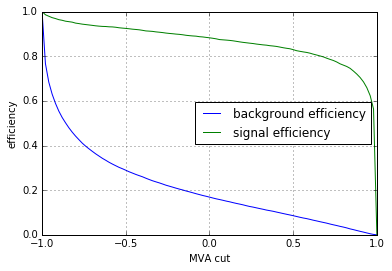

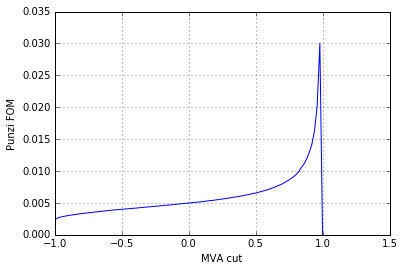

[#1] INFO:Eval -- RooRealVar::setRange(Lb_M) new range named 'lsb' created with bounds [4500,5000]
[#1] INFO:Eval -- RooRealVar::setRange(Lb_M) new range named 'rsb' created with bounds [6000,6800]

Number of trees in chain: 0

Set up 1 / 1 branches

Read in 65673 events


Lb2Lemu: Initialize 

Lb2Lemu: CreateReducedTree 

Lb2Lemu: CreateDataSet 
Candidates: 65673
[#1] INFO:Eval -- RooTreeDataStore::loadValues(data_Lb2Lemu) Ignored 18816 out of range events
RooDataSet::data_Lb2Lemu[Lb_M] = 46857 entries

Lb2Lemu: Initialized Correctly! The model is:
RooExponential::totsig_Lb2Lemu__for_Lb_M[ x=Lb_M c=b_sig_Lb2Lemu__for_Lb_M ] = 0.0593087

Lb2Lemu: PrintParams

RooRealVar::b_sig_Lb2Lemu__for_Lb_M = -0.0005  L(-1 - 1e-15) 

Lb2Lemu: Fit Lb_M__var__ (100,4500,6800) -lin-fitrange[lsb,rsb]-animated[10]
[#1] INFO:Fitting -- RooAbsOptTestStatistic::ctor(nll_totsig_Lb2Lemu__for_Lb_M_data_Lb2Lemu_lsb) constructing test statistic for sub-range named lsb
[#1] INFO:Eval -- RooRealVar::setRange(Lb_M

ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.

In [8]:
mva_cuts, eps_sig, N_B, punzi = scan_punzi(-1, 1, 0.02)
from matplotlib import pyplot as plt
b_eff_plot=plt.plot(mva_cuts,[i/(Lumi_scale_factor*N_tot_B) for i in N_B], label='background efficiency')
s_eff_plot=plt.plot(mva_cuts,[x[0] for x in eps_sig], label='signal efficiency')
plt.legend(loc='best')
plt.xlabel('MVA cut')
plt.xlim(-1,1)
plt.ylabel('efficiency')
plt.grid()
plt.savefig("eff_sig_eff_bkg.pdf")
plt.show()

plt.plot(mva_cuts,punzi)
plt.xlabel('MVA cut')
plt.ylabel('Punzi FOM')
plt.grid()
plt.savefig("punzi_full.pdf")
plt.show()

In [27]:
#cut corresponding to 90% signal efficiency
eff_B = [i/(Lumi_scale_factor*N_tot_B) for i in N_B]
pos_90_eff = [i for i, j in enumerate(eps_sig) if j[0]<=0.9][0] #0-th element of list of points with eps_sig<0.9
eff_B_at_90eff = eff_B[pos_90_eff]
mva_cut_at_90eff = mva_cuts[pos_90_eff]
print "Cut corresponding to 90% signal efficiency = MVA>", mva_cut_at_90eff
print "Corresponding background rejection: ", 1-eff_B_at_90eff

Cut corresponding to 90% signal efficiency = MVA> -0.2
Corresponding background rejection:  0.790987962611


In [9]:
mva_cuts, eps_sig, N_B, punzi = scan_punzi(0.99, 1, 0.0001)

[#1] INFO:Eval -- RooRealVar::setRange(Lb_M) new range named 'lsb' created with bounds [4500,5000]
[#1] INFO:Eval -- RooRealVar::setRange(Lb_M) new range named 'rsb' created with bounds [6000,6800]

Number of trees in chain: 0

Set up 1 / 1 branches

Read in 26 events


Lb2Lemu: Initialize 

Lb2Lemu: CreateReducedTree 

Lb2Lemu: CreateDataSet 
Candidates: 26
[#1] INFO:Eval -- RooTreeDataStore::loadValues(data_Lb2Lemu) Ignored 4 out of range events
RooDataSet::data_Lb2Lemu[Lb_M] = 22 entries

Lb2Lemu: Initialized Correctly! The model is:
RooExponential::totsig_Lb2Lemu__for_Lb_M[ x=Lb_M c=b_sig_Lb2Lemu__for_Lb_M ] = 0.0593087

Lb2Lemu: PrintParams

RooRealVar::b_sig_Lb2Lemu__for_Lb_M = -0.0005  L(-1 - 1e-15) 

Lb2Lemu: Fit Lb_M__var__ (100,4500,6800) -lin-fitrange[lsb,rsb]-animated[10]
[#1] INFO:Fitting -- RooAbsOptTestStatistic::ctor(nll_totsig_Lb2Lemu__for_Lb_M_data_Lb2Lemu_lsb) constructing test statistic for sub-range named lsb
[#1] INFO:Eval -- RooRealVar::setRange(Lb_M) new range n

ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.
ASImage2gif():1015:<Lb2Lemu.gif> 
GIF-LIB error: Wrong record type detected.

In [10]:
m = max(punzi)
pos_max = [i for i, j in enumerate(punzi) if j==m]
print "The max is the {0}-th cut, corresponding to MVA = {1}".format(pos_max, mva_cuts[pos_max[0]])
print "This cut corresponds to an expected number of background events in the region of interest of", N_B[pos_max[0]]
print "This cut corresponds to a signal efficiency of", eps_sig[pos_max[0]][0], "+/-", eps_sig[pos_max[0]][1], "(stat)"

The max is the [81]-th cut, corresponding to MVA = 0.9981
This cut corresponds to an expected number of background events in the region of interest of 0.0
This cut corresponds to a signal efficiency of 0.336704244032 +/- 0.00608481303048 (stat)


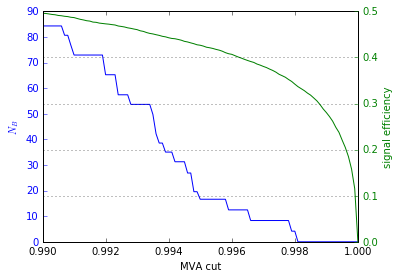

In [64]:
from matplotlib import pyplot as plt
fig, ax1 = plt.subplots()
ax1.plot(mva_cuts,N_B, label='$N_B$', color='b')
ax1.set_xlabel("MVA cut")
ax1.set_ylabel('$N_B$', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(mva_cuts,[x[0] for x in eps_sig], label='signal efficiency', color='g')
ax2.set_xlim(mva_cuts[0], mva_cuts[-1])
ax2.set_ylabel('signal efficiency', color='g')
ax2.tick_params('y', colors='g')
plt.grid()
plt.subplots_adjust(left=0.12, bottom=0.15, right=0.85, top=0.95)
plt.savefig("Nb_vs_eps.pdf")
plt.show()

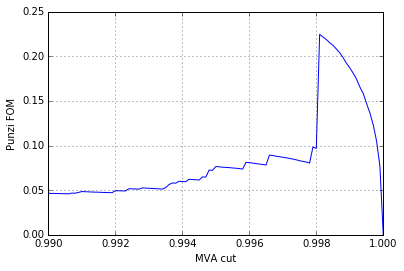

In [61]:
plt.plot(mva_cuts,punzi)
plt.xlabel('MVA cut')
plt.xlim(mva_cuts[0], mva_cuts[-1])
plt.ylabel('Punzi FOM')
plt.grid()
plt.savefig("punzi_zoom.pdf")
plt.show()

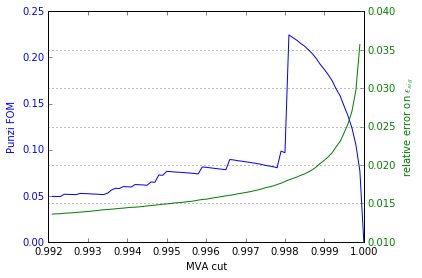

In [65]:
npoints =80 
fig, ax1 = plt.subplots()
ax1.plot(mva_cuts[-npoints:],punzi[-npoints:], color="b")
ax1.set_xlabel("MVA cut")
ax1.set_ylabel("Punzi FOM", color="b")
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
ax2.plot(mva_cuts[-npoints:-1],[x[1]/x[0] for x in eps_sig][-npoints:-1], label='signal efficiency', color="g")
ax2.set_ylabel("relative error on $\epsilon_{sig}$", color="g")
ax2.tick_params('y', colors='g')
plt.grid()
plt.subplots_adjust(left=0.12, bottom=0.15, right=0.85, top=0.95)
plt.savefig("Punzi_and_eps.pdf")
plt.show()
